In [77]:
# Configuration(Need to setting)
project_home_path = "/Users/yoonseojin/Statistics_sj"
left_hand_data_dir_path = project_home_path + "/CLMN/Replay_Exp/experiment/20210325_blueprint_0324v2/left hand"  # Left Hand
participant_name = "jonghyuk"

import os
os.chdir(project_home_path)

import pandas as pd
pd.set_option("display.width", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 500)

import numpy as np
import matplotlib.pyplot as plt

from CLMN.Replay_Exp.experiment.Replay_Experiment_Tool import mapping_data_current, single_response_only
from File_Package.sj_file_system import CsvManager
from Preprocessing_Package import sj_util
from Higher_function.sj_higher_function import flatten_2d, recursive_map

seq1 = ["4","1","3","2","4"]
seq2 = ["1","4","2","3","1"]
seq1_name = "['4', '1', '3', '2', '4']"
seq2_name = "['1', '4', '2', '3', '1']"
seq1_color = "blue"
seq2_color = "red"

divided_count = 4 # 4개 interval = 모든 시퀀스 입력 완료

def find_index(previous_datas, target_seq):
    """
    :param datas: 이전 데이터들
    :param target_seq: 입력해야 하는 sequence
    
    return: {
        previous_correct_index: 이전의 맞은 index,
        current_target_index: 현재 입력해야 하는 index
    }
    """
    
    correct_previous_data_index = -1
    current_target_index = 0
    for i in range(0, len(previous_datas)):
        if previous_datas.iloc[i]["Response"] == target_seq[current_target_index]:
            correct_previous_data_index = i
            current_target_index += 1
            
        if current_target_index >= len(target_seq):
            # 한 시퀀스를 모두 다 찾았을때, index 초기화
            current_target_index = 0
            correct_previous_data_index = -1
            
    return {
        "previous_correct_index" : correct_previous_data_index,
        "current_target_index" : current_target_index
    }

In [2]:
def intertap_interval(mapped_datas):
    response_times_across_runs = []
    for run_index in range(0, len(mapped_datas)):
        response_times_per_run = []
        # groupby를 step으로 처리
        for step_name, step_group in mapped_datas[run_index].groupby("Step"):
            # intertap interval 정의
            # 한 스텝에서 처음 시퀀스가 완료된 경우: 현재 반응시간 - 자극 시간
            # 그 외의 경우: 현재 반응 시간 - 이전의 맞는 입력의 반응시간
            response_times_per_step = []
            for group_row_index in range(0, len(step_group)):
                current_row = step_group.iloc[group_row_index]
                target_seq = []
                if current_row["Stimulus"] == seq1_name:
                    target_seq = seq1
                else:
                    target_seq = seq2

                # 이전에 있는 입력들중 맞는 입력이 있는지 체크
                # 만약 맞는 입력이 없다면 stimulus의 자극 시간과 비교
                find_result = find_index(previous_datas = step_group[0:group_row_index], 
                                         target_seq = target_seq)
                previous_correct_index = find_result["previous_correct_index"]
                current_target_index = find_result["current_target_index"]

                if previous_correct_index == -1:
                    continue
                else:
                    previous_correct_row = step_group.iloc[previous_correct_index]
                    if target_seq[current_target_index] == current_row["Response"]:
                        response_times_per_step.append([(previous_correct_row["Response"], current_row["Response"]), current_row["response_seconds"] - previous_correct_row["response_seconds"]])
            response_times_per_run.append({
                "Step": step_name,
                "Response_times": response_times_per_step
            })
        response_times_across_runs.append(response_times_per_run)
    return response_times_across_runs


In [3]:
"""
Load Data
"""
stimuluses = []
responses = []
for i in range(0, 4):
    stimulus_file_name = "stimulus_" + participant_name + "_" + str(i)
    response_file_name = "response_" + participant_name + "_" + str(i)
    stimuluses.append( CsvManager(dir_path=left_hand_data_dir_path, file_name=stimulus_file_name).read_csv_from_pandas()[2:-1] ) # remove not necessary data
    responses.append( CsvManager(dir_path=left_hand_data_dir_path, file_name=response_file_name).read_csv_from_pandas() )
stimuluses[-1] = stimuluses[-1][:-1] # remove not necessary data

mapped_d = mapping_data_current(stimuluses, responses)
mapped_d = single_response_only(mapped_d)
intertap_intervals = intertap_interval(mapped_d)

In [5]:
"""
시퀀스 별로 그래프 드로잉
"""
def all_sequence_inter_step_in_runs(steps, response_times):
    # step을 complete sequence를 입력한 단위로 쪼갬

    start_point = 0 # fixed value
    divided_count = 4 # 4개 interval = 모든 시퀀스 입력 완료

    all_inter_steps_in_run = []
    for step_index in range(0, len(steps)):
        step = steps[step_index]
        parition_count = len(response_times[step_index]) / divided_count
        parition_count = int(np.ceil(parition_count))
        inter_steps = list(map(lambda x: x[start_point], sj_util.partition_d1(start_value = step, end_value = step + 1, partition_count = parition_count)))
        all_inter_steps_in_run.append(inter_steps)
    return all_inter_steps_in_run

def response_complete_sequence(steps, response_times):
    # complete sequence 단위로 intertap interval을 묶음
    response_per_complete_sequence = []
    all_response_per_complete_sequence = []
    
    # make coordinate
    for step_index in range(0, len(steps)): # iterate all step
        response_step = response_times[step_index]
        for tap_index in range(0, len(response_times[step_index])): # iterate all tap
            if tap_index % divided_count == 0:
                response_per_complete_sequence = []
                response_per_complete_sequence.append(response_step[tap_index])
            else:
                response_per_complete_sequence.append(response_step[tap_index])
            if len(response_per_complete_sequence) == divided_count:
                all_response_per_complete_sequence.append(response_per_complete_sequence)      
            elif tap_index == len(response_times[step_index]) - 1: # 마지막 시퀀스
                all_response_per_complete_sequence.append(response_per_complete_sequence)
                
    return all_response_per_complete_sequence

def intertap_coords_per_sequence(steps, response_times):
    # complete sequence 단위로 좌표를 만듦
    all_inter_step_in_runss = all_sequence_inter_step_in_runs(steps, response_times)
    all_response_per_complete_sequence = response_complete_sequence(steps, response_times)

    flat_all_inter_step_runs = flatten_2d(all_inter_step_in_runss)

    inter_tap_responses_coord = []
    for e in zip(flat_all_inter_step_runs, all_response_per_complete_sequence):
        for inter_tap in e[1]:
            inter_tap_responses_coord.append([e[0], inter_tap])

    return inter_tap_responses_coord

In [334]:
def get_intertap_response_per_sequence(run_index, intertap_intervals):
    steps = list(map(lambda x: x["Step"], intertap_intervals[run_index]))
    response_times = list(map(lambda x: list(map(lambda a: a[1], x["Response_times"])) , intertap_intervals[run_index]))
    intertap_responses_coord = intertap_coords_per_sequence(steps, response_times)
    return intertap_responses_coord

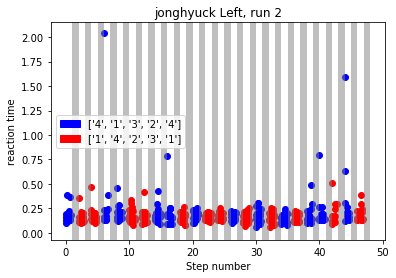

In [568]:
"""
한 스텝에서 성공한 시퀀스 별로
성공한 스텝이 많다면, step 내부에서 sub interval로 많이 갈라짐
"""
def plot_per_sequence(run_index, intertap_intervals):
    intertap_responses_coord = get_intertap_response_per_sequence(run_index = run_index, 
                                                                  intertap_intervals = intertap_intervals)

    x_values = list(map(lambda x: x[0], intertap_responses_coord))
    y_values = list(map(lambda x: x[1], intertap_responses_coord))

    seq1_steps = np.array(list(stimuluses[run_index][stimuluses[run_index]["Stimulus"] == seq1_name]["Step"]))

    for i in range(0, len(x_values)):
        if int(x_values[i]) in seq1_steps:
            plt.scatter(x = x_values[i], y = y_values[i], color = seq1_color)
        else:
            plt.scatter(x = x_values[i], y = y_values[i], color = seq2_color)

    plt.ylabel("reaction time")
    plt.xlabel("Step number")
    plt.title("jonghyuck Left, run " + str(run_index))

    # Show rest
    steps = np.array(list(map(lambda x: x["Step"], intertap_intervals[run_index])))
    for step in steps:
        plt.axvspan(step+1, step+2, facecolor='gray', alpha=0.5)

    # draw Legend
    import matplotlib.patches as mpatches
    patch_seq1 = mpatches.Patch(color=seq1_color, label=seq1)
    patch_seq2 = mpatches.Patch(color=seq2_color, label=seq2)
    plt.legend(handles=[patch_seq1, patch_seq2])

plot_per_sequence(0, intertap_intervals)

In [107]:
"""
response 하나하나 별로 그래프 드로잉
"""

def all_inter_step_in_runs(steps,response_times):
    start_point = 0 # fixed value
    divided_count = 4 # 4개 interval = 모든 시퀀스 입력 완료

    all_inter_steps_in_run = []
    for step_index in range(0, len(steps)):
        step = steps[step_index]
        response_step = response_times[step_index]
        divided_count = len(response_step)
        inter_steps = list(map(lambda x: x[start_point], sj_util.partition_d1(start_value = step, end_value = step + 1, partition_count = divided_count)))
        all_inter_steps_in_run.append(inter_steps)
    return all_inter_steps_in_run

def get_intertap_response(run_index, intertap_intervals):
    steps = list(map(lambda x: x["Step"], intertap_intervals[run_index]))
    response_times = list(map(lambda x: list(map(lambda a: a[1], x["Response_times"])) , intertap_intervals[run_index]))
    
    coords = zip(all_inter_step_in_runs(steps, response_times), response_times)
    
    coords_list = []
    for e in coords:
        coords_list.append(list(e))
    return coords_list


In [349]:
def drawing_graph(coords, steps, seq1_steps):
    for i in range(0, len(coords)):
        inter_step = coords[i][0]
        response_time_step = coords[i][1]

        for j in range(0, len(inter_step)):
            if int(inter_step[j]) in seq1_steps:
                plt.plot(inter_step, response_time_step, color=seq1_color)
            else:
                plt.plot(inter_step, response_time_step, color=seq2_color)

    plt.xlabel("Step number")
    plt.ylabel("Intertap Interval")

    # Show mean
    means_per_step = []
    for i in range(0, len(coords)):
        inter_step = coords[i][0]
        response_time_step = coords[i][1]
        means_per_step.append([np.mean(inter_step), np.mean(response_time_step)])

    # Show rest
    for i in range(0, len(steps)):
        step = steps[i]

        if i != len(steps)-1:
            plt.axvspan(step + 1, step + 2, facecolor='gray', alpha=0.5)

    mean_color = "green"
    for data in means_per_step:
        plt.scatter(data[0], data[1], color=mean_color, s=10, zorder=10)

    # draw Legend
    import matplotlib.patches as mpatches
    patch_seq1 = mpatches.Patch(color=seq1_color, label=seq1)
    patch_seq2 = mpatches.Patch(color=seq2_color, label=seq2)
    patch_avg = mpatches.Patch(color=mean_color, label="avg")
    plt.legend(handles=[patch_seq1, patch_seq2, patch_avg])

    # draw session
    s = mpatches.Rectangle(
        (min(steps), 0),  # (x, y)
        max(steps) - min(steps) + 1, 1,  # width, height
        edgecolor='deeppink',
        facecolor='none',
        zorder=15
    )

    ax = plt.gca()
    ax.add_patch(s)

Text(0.5, 1.0, 'jonghyuck run: 0')

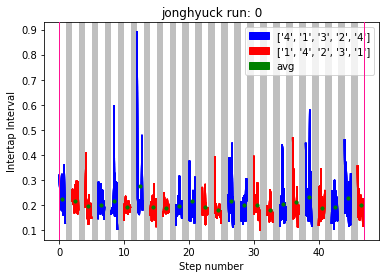

In [350]:
run_index = 0
coords = get_intertap_response(run_index, intertap_intervals)
steps = np.array(list(map(lambda x: x["Step"], intertap_intervals[run_index])))
seq1_steps = np.array(list(stimuluses[run_index][stimuluses[run_index]["Stimulus"] == seq1_name]["Step"]))
drawing_graph(coords, steps, seq1_steps)
plt.title("jonghyuck run: 0")

Text(0.5, 1.0, 'jong hyuck run 0~3')

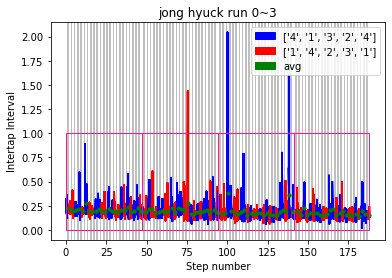

In [351]:
def draw_continuos_graph(stimuluses, intertap_intervals):
    padding = 1
    last_step = 0
    for run_index in range(0, len(stimuluses)):
        steps = np.array(list(map(lambda x: x["Step"], intertap_intervals[run_index])))

        seq1_steps = np.array(list(stimuluses[run_index][stimuluses[run_index]["Stimulus"] == seq1_name]["Step"])) + last_step
        coords = get_intertap_response(run_index, intertap_intervals)
        coords = list(map(lambda x: [np.array(x[0]) + last_step, np.array(x[1])], coords))
        steps = np.array(list(map(lambda x: x["Step"], intertap_intervals[run_index]))) + last_step
        last_step = max(steps) + padding
        drawing_graph(coords, steps, seq1_steps)
draw_continuos_graph(stimuluses, intertap_intervals)
plt.title("jong hyuck run 0~3")

In [352]:
def draw_multi_graph(stimuluses, intertap_intervals, run_indexes):
    # stimuluses 의 길이가 동일하다고 가정
    
    i = 0
    padding = 1
    for run_index in run_indexes:
        adding = run_index * len(stimuluses[run_index])
        
        if i != 0:
            adding += padding
            
        steps = np.array(list(map(lambda x: x["Step"], intertap_intervals[run_index])))

        seq1_steps = np.array(list(stimuluses[run_index][stimuluses[run_index]["Stimulus"] == seq1_name]["Step"])) + adding
        coords = get_intertap_response(run_index, intertap_intervals)
        coords = list(map(lambda x: [np.array(x[0]) + adding, np.array(x[1])], coords))
        steps = np.array(list(map(lambda x: x["Step"], intertap_intervals[run_index]))) + adding
        
        i+=1
        drawing_graph(coords, steps, seq1_steps)
        

Text(0.5, 1.0, 'jong hyuck run 0, 3')

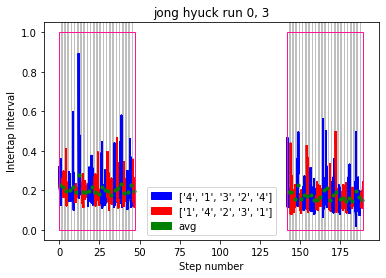

In [353]:
draw_multi_graph(stimuluses, intertap_intervals, [0, 3])
plt.title("jong hyuck run 0, 3")

In [556]:
def plot_learning(run_index, intertap_intervals):
    coords = get_intertap_response(run_index, intertap_intervals)

    response_index = 1

    # 모든 스텝에 대하여 loop
    total_intertap_diffs = []
    for i in range(0, len(coords)):
        coord = coords[i]
        next_coord = None
        if i+1 < len(coords):
            next_coord = coords[i+1]

        response_coord = coord[response_index]

        # 한 스텝에 해당하는 값들
        intertap_diffs = []
        for j in range(0, len(response_coord), divided_count):
            first_intertap = response_coord[j]
            last_intertap = None

            deltal_last_sequence_index = divided_count - 1
            last_sequence_index = j + deltal_last_sequence_index
            if last_sequence_index < len(response_coord):
                last_intertap = response_coord[last_sequence_index]

            if last_intertap != None:
                intertap_diff = first_intertap - last_intertap # first intertap - last intertap
                intertap_diffs.append(intertap_diff)

        total_intertap_diffs.append(intertap_diffs)

    total_intertap_diffs = np.array([np.array(e) for e in total_intertap_diffs]) # sequence last - first

    means = []
    for i in range(0, len(total_intertap_diffs)):
        means.append(np.mean(total_intertap_diffs[i]))

    MOGs = [] # Micro offline gain, difference between (mean intertap of next stimulus step) and (mean intertap of specific step)
    for i in range(0, len(means)):
        if i+1 < len(means):
            MOGs.append(means[i+1] - means[i])

    MOnGs = [] # Micro online gaine, difference between specific step's last sequence and specific step's first sequence
    for i in range(0, len(total_intertap_diffs)):
        MOnGs.append(total_intertap_diffs[i][-1] - total_intertap_diffs[i][0])

    Total_learning = np.array(MOnGs[0:-1]) + np.array(MOGs) # Sum of MOGs and MOnGs

    plt.scatter(np.repeat(0, len(MOGs)), MOGs)
    plt.scatter(np.repeat(1, len(MOnGs)), MOnGs)
    plt.scatter(np.repeat(-1, len(Total_learning)), MOGs)
    
    plt.scatter(0, np.mean(MOGs), color="red", s = 80)
    plt.scatter(1, np.mean(MOnGs), color="red", s = 80)
    plt.scatter(-1, np.mean(Total_learning), color="red", s = 80)
    
    plt.xticks([-1, 0, 1], ["Total learning", "MOGs", "MonGs"])
    plt.ylabel("Sum of deltas")
    plt.title("jonghyuck left, run " + str(run_index))


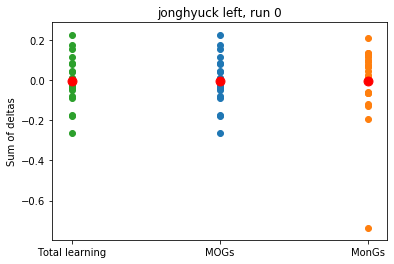

In [573]:
# + value는 learning이 개선된것
plot_learning(0, intertap_intervals)

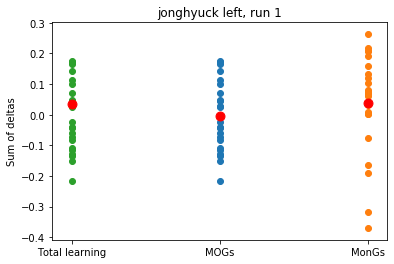

In [569]:
plot_learning(1, intertap_intervals)

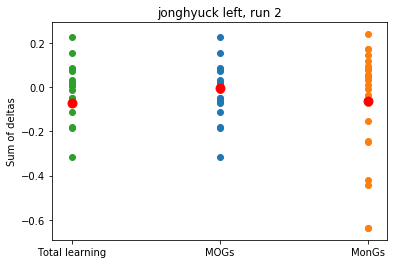

In [570]:
plot_learning(2, intertap_intervals)

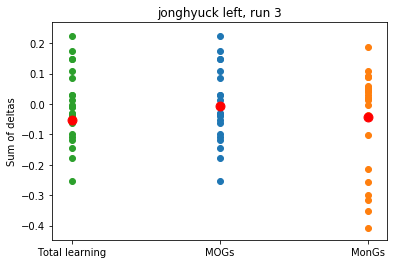

In [571]:
plot_learning(3, intertap_intervals)